In [1]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline, UNet2DModel
from datasets import load_dataset

from urllib.request import urlopen 
import json 


os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_cifar10_generated.png")

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [2]:
from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype


def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
cifar10_iterator = iter(cifar10)

PermissionError: [Errno 13] Permission denied: '/run/media/anton'

In [ ]:
similarity = []

img_generated = transform(image)

for i, data in enumerate(cifar10):
    img_test = transform(data["img"])
    
    m = torch.sum(
        (img_generated / torch.norm(img_generated)) * 
        (img_test / torch.norm(img_test))
    )
    # m = torch.norm(img_test - img_generated)
    
    similarity.append(m)

    print(i) if i%1000==0 else None
    
plt.hist(similarity)
similarity = np.array(similarity)

In [ ]:
#similarity_unsorted = similarity

n = 1000
top_n_idx = np.argsort(similarity)[-n:]
top_n_idx

In [ ]:
top_n_img = []

for i, data in enumerate(cifar10): 
    if i in top_n_idx:
        top_n_img.append(data["img"])


In [ ]:
plt.imshow(np.moveaxis(img_generated.numpy(), 0, -1))

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

axs = axs.flatten()

for j in range(100):
    axs[j].imshow(np.moveaxis(transform(top_n_img[j]).numpy(), 0, -1))

In [ ]:
M_top = torch.stack([torch.flatten(transform(img)) * 2 - 1 for img in top_n_img])
svd_top = torch.svd(M_top)
# pca_top = torch.pca_lowrank(M_top, center=True)


# pca_top[2].shape

svd_top.V.t().shape

In [ ]:
plt.plot(svd_top.S.numpy())

In [ ]:
fig, axs = plt.subplots(5, 10, figsize=(15, 5))

n_top_sv = 50

axs = axs.flatten()

for j in range(n_top_sv):
    sv_reshaped = svd_top.V.t()[j].reshape((3,32,32)) / 2 + 0.5
    # sv_reshaped = pca_top[2].t()[j].reshape((3,32,32)) / 2 + 0.5

    sv_reshaped /= torch.max(torch.abs(sv_reshaped))

    axs[j].imshow(
        np.moveaxis(sv_reshaped.numpy(), 0, -1)
    )


## Within-class PCA

In [64]:
cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
cifar10_iterator = iter(cifar10)

samples = []
n_sample = 1000
label_idx = 6


for data in cifar10:
    if int(data['label']) == label_idx and len(samples) < n_sample:
        samples.append(data["img"])

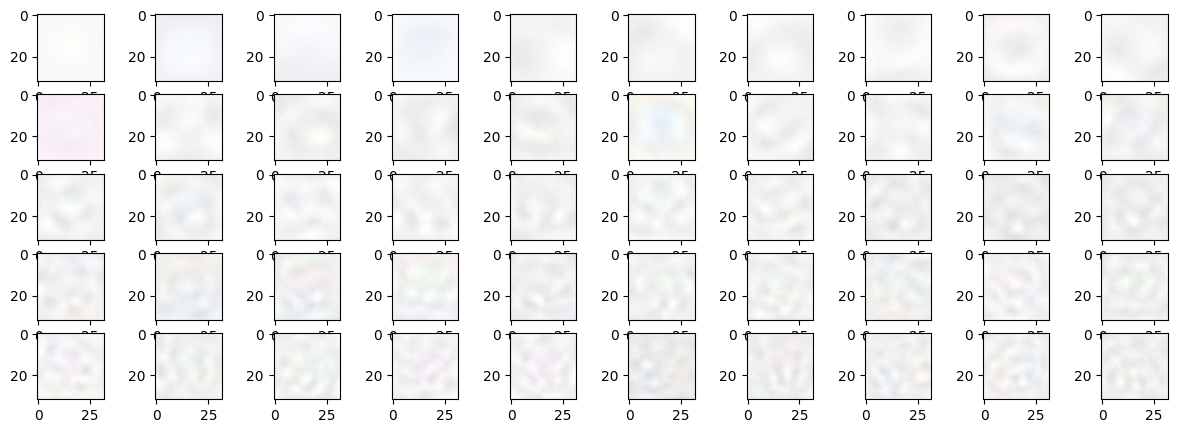

In [68]:
M_sample = torch.stack([torch.flatten(transform(img)) * 2 - 1 for img in samples])
svd_sample = torch.svd(M_sample)

fig, axs = plt.subplots(5, 10, figsize=(15, 5))

n_top_sv = 50

axs = axs.flatten()

for j in range(n_top_sv):
    sv_reshaped = svd_sample.V.t()[j].reshape((3,32,32)) / 2 + 0.5
    # sv_reshaped = pca_top[2].t()[j].reshape((3,32,32)) / 2 + 0.5

    sv_reshaped /= torch.max(torch.abs(sv_reshaped))

    axs[j].imshow(
        np.moveaxis(sv_reshaped.numpy(), 0, -1)
    )


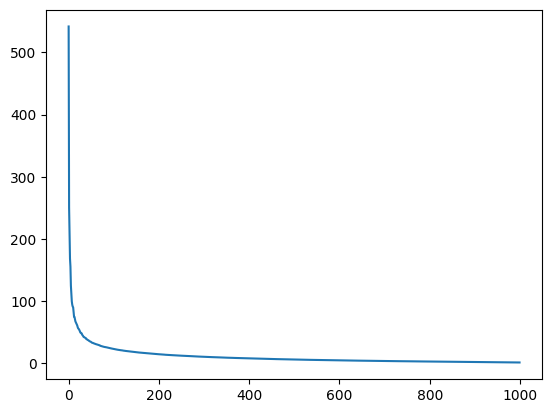

In [66]:
plt.plot(svd_sample.S)